# FashionMnist分类任务正则化对比实验

## 一、实验目的

本实验基于MindSpore框架搭建的卷积神经网络，实现基于Fshion-Mnist数据集的分类识别任务，并对比有无正则化处理对训练结果的影响。


## 二、正则化原理介绍

正则化是机器学习中一种常用的技术，广泛应用于不同的机器学习算法，如线性回归、逻辑回归、支持向量机等。正则化通过在模型的损失函数中增加一个正则项，惩罚模型的复杂度，从而抑制模型对训练数据的过度拟合，提高模型的泛化能力。常见的正则化技术有L1正则化（Lasso正则化）、L2正则化（Ridge正则化）和Elastic Net正则化。

正则化的目标是最小化以下形式的带正则项的损失函数：

    L_reg = L + λ * R(w)

其中，L是原始的损失函数，R(w)是正则化项，w表示模型的参数，λ是正则化参数（用于控制正则化的强度）。

常见的正则化项包括L1正则化和L2正则化：

- L1正则化（Lasso正则化）：
  
    R(w) = ||w||₁ = Σ|w_i|

    其中，||w||₁表示参数w的L1范数（绝对值之和），w_i表示参数w的第i个分量。

- L2正则化（Ridge正则化）：
  
    R(w) = ||w||₂² = Σ(w_i)²

    其中，||w||₂表示参数w的L2范数（平方和），w_i表示参数w的第i个分量。

通过调节正则化参数λ，我们可以控制正则化项在整个损失函数中的影响程度。较大的λ会增加正则化的影响，降低模型的复杂度；较小的λ会减少正则化的影响，模型更容易过拟合。

通过在损失函数中引入正则项，正则化技术可以限制模型参数的取值范围或降低模型的复杂度，从而改善模型的泛化能力，减少过拟合的风险。

以上。通过适当选择正则化技术和调节正则化参数，可以有效地控制模型的复杂度，提高模型的泛化性能，避免过拟合问题。

## 三、实验环境

实验开发环境描述：

- 编程语言和框架：使用Python（3.7）编程语言和MindSpore（2.0）框架进行实验开发和深度学习模型训练。

- 开发工具和环境：使用VS-code作为主要的集成开发环境（IDE），在Windows或Linux操作系统上进行开发。

- 硬件和资源要求：实验要求使用具备GPU加速或MindSpore支持的Ascend芯片进行训练和推理计算。可以在本地机器或云计算平台上进行实验。

- 其他依赖项：NumPy、Matplotlib、easydict、struct

- 实验数据集：Fashion-mnist公开数据集。

## 四、数据处理

### Fashion-Mnist数据集介绍

Fashion-MNIST是一个广泛使用的图像分类数据集，旨在替代经典的MNIST手写数字数据集。Fashion-MNIST由Zalando Research创建，包含了一系列服装商品的灰度图像。

以下是Fashion-MNIST数据集的一些关键特点：

- 图像内容：
    Fashion-MNIST数据集包含10个类别的服装商品图像。这些类别分别是：T恤/上衣、裤子、套衫、连衣裙、外套、凉鞋、衬衫、运动鞋、手提包和踝靴。每个类别包含6000个训练样本和1000个测试样本。以下表格列举了fashion-mnist数据集的十个类别标签：

    | 标签 | 描述           |
    |------|----------------|
    | 0    | T-shirt/top    |
    | 1    | Trouser        |
    | 2    | Pullover       |
    | 3    | Dress          |
    | 4    | Coat           |
    | 5    | Sandal         |
    | 6    | Shirt          |
    | 7    | Sneaker        |
    | 8    | Bag            |
    | 9    | Ankle boot     |

- 图像属性：
    每张图像的尺寸为28x28像素，灰度图像（单通道），像素值范围为0到255之间。

- 数据集规模：
    Fashion-MNIST数据集共有70000个图像样本，其中60000个用于训练，10000个用于测试。这使得该数据集可以用于训练机器学习模型和评估模型性能。

- 挑战性：
    相较于经典的MNIST数据集，Fashion-MNIST在图像复杂度和难度上有所提升。图像内容更加多样化和具有挑战性，更贴近实际应用场景。因此，Fashion-MNIST数据集被广泛用于验证算法的鲁棒性和泛化能力。

Fashion-MNIST数据集的可用性和易用性使其成为学术界和工业界中广泛应用的基准数据集之一。它可用于训练和评估图像分类算法，例如卷积神经网络（CNN）和其他机器学习模型，以解决服装商品分类、图像识别和相关问题。

### 数据集下载

以下代码实现了Fashion-Mnist数据集的下载。请确保下载后的数据集目录结构如下：

- fashion-mnist
    - train
        - train-images-idx3-ubyte
        - train-labels-idx1-ubyte
    - test
        - t10k-images-idx3-ubyte
        - t10k-labels-idx1-ubyte


In [56]:
# 下载fashion-mnist数据集
from download import download

dataset_url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com/deep-learning/fashion-mnist.zip"
path = "./"
path = download(dataset_url, path, kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 30.9M/30.9M [00:00<00:00, 43.2MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [57]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor

# context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')
context.set_context(mode=context.GRAPH_MODE, device_target='GPU')

In [58]:
cfg = edict({
    'train_size': 60000,  # 训练集大小
    'test_size': 10000,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 64,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 20,  # 训练次数
    'data_dir_train': os.path.join('fashion-mnist', 'train'),
    'data_dir_test': os.path.join('fashion-mnist', 'test'),
})

In [59]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs, np.float32).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label, np.int32)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


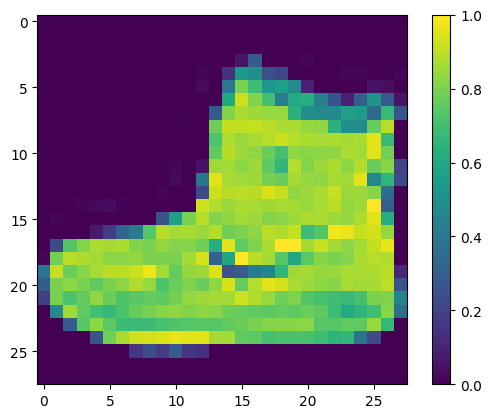

In [60]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0

print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0])  # 一共10类，用0-9的数字表达类别。

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [61]:
# 转换数据类型为Dataset
def create_dataset():
    XY_train = list(zip(train_x, train_y))
    ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
    ds_train = ds_train.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    XY_test = list(zip(test_x, test_y))
    ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
    ds_test = ds_test.shuffle(buffer_size=1000).batch(cfg.batch_size, drop_remainder=True)
    return ds_train, ds_test

## 五、模型构建

该实验中，可以选择使用不含正则化的卷积神经网络或者选择加入正则化的卷积神经网络，用于对比结果。
下面这部分用于创建不加入正则化的卷积神经网络，网络结构为：卷积层1卷积层2卷积层3最大池化层全连接层1全连接层2。

In [62]:
# 定义卷积神经网络，无正则化
class ForwardFashion(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashion, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = ops.relu(x)
        x = self.conv2(x)
        x = ops.relu(x)
        x = self.conv3(x)
        x = ops.relu(x)
        x = self.maxpool2d(x)
        x = ops.flatten(x)
        x = self.fc1(x)
        x = ops.relu(x)
        x = self.fc2(x)
        return x

下面这部分用于创建加入正则化的卷积神经网络，网络结构为卷积层1dropout层1卷积层2dropout层1卷积层3dropout层1最大池化层 dropout层2全连接层1 dropout层2全连接层2：

In [63]:
# 定义卷积神经网络，有正则化
class ForwardFashionRegularization(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(ForwardFashionRegularization, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Dense(3200, 128)
        self.bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.conv1(x)
        x = ops.relu(x)
        x = self.conv2(x)
        x = ops.relu(x)
        x = self.maxpool2d(x)
        x = ops.dropout(x, p=0.5)
        x = self.conv3(x)
        x = ops.relu(x)
        x = self.maxpool2d(x)
        x = ops.dropout(x, p=0.5)
        x = ops.flatten(x)
        x = self.fc1(x)
        x = ops.relu(x)
        x = self.bn(x)
        x = ops.dropout(x, p=0.5)
        x = self.fc2(x)
        return x

## 六、模型训练

为这个模型指定优化器（adam）、损失函数（crossentropy）和度量(accuracy)，然后启动训练，最后进行验证。

In [64]:
def train(Net):
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Net(cfg.num_classes)
    # 定义模型的损失函数，优化器
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})
    loss_cb = LossMonitor()
    print("============== Starting Training ==============")
    model.train(30, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    
    return model

In [65]:
# 训练无正则化的网络
model = train(ForwardFashion)

============== Starting Training ==============
epoch: 1 step: 937, loss is 0.4309420585632324
epoch: 2 step: 937, loss is 0.28682684898376465
epoch: 3 step: 937, loss is 0.1592390239238739
epoch: 4 step: 937, loss is 0.342265784740448
epoch: 5 step: 937, loss is 0.279633492231369
epoch: 6 step: 937, loss is 0.11567063629627228
epoch: 7 step: 937, loss is 0.0794147476553917
epoch: 8 step: 937, loss is 0.06936568766832352
epoch: 9 step: 937, loss is 0.025324471294879913
epoch: 10 step: 937, loss is 0.05986649543046951
epoch: 11 step: 937, loss is 0.009884053841233253
epoch: 12 step: 937, loss is 0.08511004596948624
epoch: 13 step: 937, loss is 0.02507101185619831
epoch: 14 step: 937, loss is 0.006803958211094141
epoch: 15 step: 937, loss is 0.02478655055165291
epoch: 16 step: 937, loss is 0.22395557165145874
epoch: 17 step: 937, loss is 0.15118847787380219
epoch: 18 step: 937, loss is 0.0777982696890831
epoch: 19 step: 937, loss is 0.04976671189069748
epoch: 20 step: 937, loss is 0.0113

In [66]:
# 训练有正则化的网络
model = train(ForwardFashionRegularization)

============== Starting Training ==============
epoch: 1 step: 937, loss is 0.6705112457275391
epoch: 2 step: 937, loss is 0.29744866490364075
epoch: 3 step: 937, loss is 0.2999320328235626
epoch: 4 step: 937, loss is 0.4017154276371002
epoch: 5 step: 937, loss is 0.3760083317756653
epoch: 6 step: 937, loss is 0.17504505813121796
epoch: 7 step: 937, loss is 0.22998952865600586
epoch: 8 step: 937, loss is 0.3527829349040985
epoch: 9 step: 937, loss is 0.40792036056518555
epoch: 10 step: 937, loss is 0.3625226616859436
epoch: 11 step: 937, loss is 0.2909747064113617
epoch: 12 step: 937, loss is 0.37289246916770935
epoch: 13 step: 937, loss is 0.2561287581920624
epoch: 14 step: 937, loss is 0.09648163616657257
epoch: 15 step: 937, loss is 0.2992987334728241
epoch: 16 step: 937, loss is 0.1584387570619583
epoch: 17 step: 937, loss is 0.1661819964647293
epoch: 18 step: 937, loss is 0.37405306100845337
epoch: 19 step: 937, loss is 0.13107478618621826
epoch: 20 step: 937, loss is 0.2321754842

## 七、模型预测

使用上述训练好的模型对测试数据集进行预测。打印预测结果

In [67]:
# 预测
ds_test, _ = create_dataset()
test_ = ds_test.create_dict_iterator(output_numpy=True).__next__()
predictions = model.predict(Tensor(test_['x']))
predictions = predictions.asnumpy()
for i in range(15):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    print('第' + str(i) + '个sample预测结果：', p_list.index(max(p_list)), '   真实结果：', test_['y'][i])

第0个sample预测结果： 7    真实结果： 7
第1个sample预测结果： 2    真实结果： 0
第2个sample预测结果： 0    真实结果： 0
第3个sample预测结果： 5    真实结果： 5
第4个sample预测结果： 2    真实结果： 2
第5个sample预测结果： 0    真实结果： 0
第6个sample预测结果： 5    真实结果： 5
第7个sample预测结果： 4    真实结果： 4
第8个sample预测结果： 7    真实结果： 7
第9个sample预测结果： 8    真实结果： 8
第10个sample预测结果： 8    真实结果： 8
第11个sample预测结果： 0    真实结果： 0
第12个sample预测结果： 7    真实结果： 7
第13个sample预测结果： 7    真实结果： 7
第14个sample预测结果： 2    真实结果： 2


In [68]:
# -------------------定义可视化函数--------------------------------
# 输入预测结果序列，真实标签序列，以及图片序列
# 目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为红色；错：标签为蓝色
def plot_image(predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # 显示对应图片
    plt.imshow(img, cmap=plt.cm.binary)
    # 显示预测结果的颜色，如果对上了是蓝色，否则为红色
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 显示对应标签的格式，样式
    plt.xlabel('{},{:2.0f}% ({})'.format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]), color=color)


In [69]:
# 将预测的结果以柱状图形状显示蓝对红错
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

In [70]:
import numpy as np
def softmax_np(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x/np.sum(exp_x)
    return softmax_x

预测结果可视化，输入预测结果序列，真实标签序列，以及图片序列。目标是根据预测值对错，让其标签显示为红色或者蓝色。对：标签为蓝色；错：标签为红色。最后预测15个图像与标签，将预测的结果以柱状图形状显示蓝对红错。

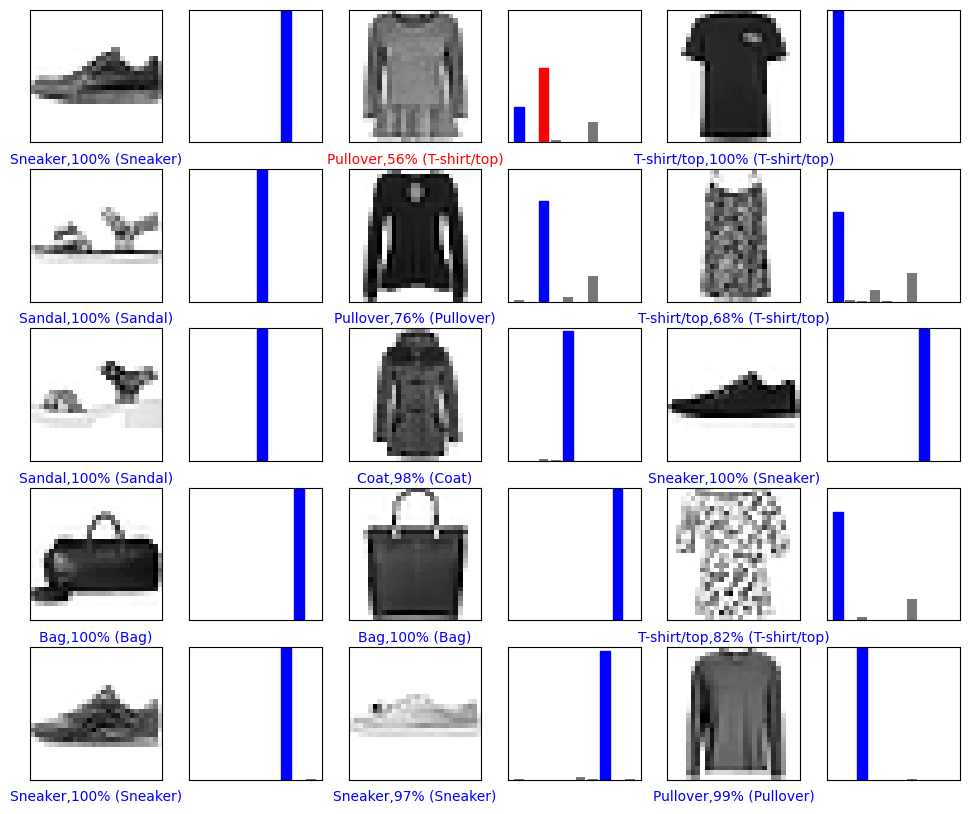

In [71]:
# 预测15个图像与标签，并展现出来
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    pred_np_ = predictions[i, :]
    pred_np_ = softmax_np(pred_np_)
    plot_image(pred_np_, test_['y'][i], test_['x'][i, 0, ...])
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(pred_np_, test_['y'][i])
plt.show()